#### Pathological Myopia

Myopia has grown to be a serious worldwide public health issue. About one-third of myopic people develop high myopia, which causes axial elongation and may result in degenerative changes to the retina and choroid. High myopia can develop into pathological myopia (PM), which is defined by anatomical alterations in particular areas as myopic refraction rises: Retino-choroidal degeneration, posterior staphyloma, and tessellated fundus are all found at the posterior pole. Tilting and parapapillary atrophy are signs of optic disc disease.

Myopic Maculopathy: Characteristics including choroidal neovascularization (CNV), Fuchs patches, and lacquer cracks are noticeable.
Because pathological myopia can cause irreparable vision loss, early diagnosis and regular monitoring are crucial.

Two goals are the main focus of this challenge:
Classification: Distinguishing between standard fundus images and those that have myopia.
Segmentation: Identifying and marking typical lesions in pathological myopia, such as retinal atrophy, haemorrhage, and macular damage.
The dataset comprises fundus photographs captured using the Zeiss Visucam 500.

#### Tasks

Task 1: Classification of Pathological Myopia (PM) and Non-PM Fundus Images
The first task involves classifying fundus images into PM and non-PM categories, with the latter including high myopia (HM) and typical cases. The reference standard for PM diagnosis is derived from comprehensive health records integrating fundus images with additional diagnostic tools, such as Optical Coherence Tomography (OCT) and visual acuity tests. PM, HM, and standard labels are included in the image filenames for training purposes.
Output Format: Submit a CSV file titled classification_results.csv with two columns:
Column 1: Filename of the test fundus image (e.g., image_01.jpg).
Column 2: Predicted probability (ranging from 0.0 to 1.0) that the image corresponds to a patient with PM.
Task 2: Optic Disc Detection and Segmentation
This task requires accurate identification and segmentation of the optic disc in fundus images. Pixel-level annotations were created by seven independent ophthalmologists, with a senior specialist consolidating these annotations into a single reference standard. Segmentation masks are provided as BMP files with the exact dimensions as the corresponding fundus images. The pixel values are:
0: Optic Disc (Black).
255: Background/Other Structures (White).

#### Evaluation Criteria
Algorithmic performance will be assessed across four tasks:
Binary Classification: PM versus non-PM, evaluated using accuracy and AUC.
Optic Disc Segmentation: Performance metrics include pixel accuracy and Dice coefficient.
Fovea Localization: Accuracy based on the distance between predicted and actual fovea locations.
Lesion Segmentation: Evaluated using precision, recall, and intersection-over-union (IoU) for detecting pathological features such as retinal atrophy and haemorrhages.
This challenge aims to enhance automated diagnostic capabilities for pathological myopia, supporting early detection and improving patient care outcomes.


### Setup


In [ ]:
! curl -L https://www.dropbox.com/s/xl4ibhwjpzfy4t8/PALM-Training400.zip?dl=1 > PALM-Training400.zip
! curl -L https://www.dropbox.com/s/5yk7vfb71c00557/PALM-Training400-Annotation-D%26F.zip?dl=1 > PALM-Training400-Annotation-D%26F.zip
! curl -L https://www.dropbox.com/s/mxk4x5ufhkuudq1/PALM-Training400-Annotation-Lession.zip?dl=1 > PALM-Training400-Annotation-Lession.zip
! curl -L https://www.dropbox.com/s/a0wpxmss89wlapq/PALM-Validation400.zip?dl=1 > PALM-Validation400.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  488M  100  488M    0     0  42.0M      0  0:00:11  0:00:11 --:--:-- 45.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 63.8M  100 63.8M    0     0  28.5M      0  0:00:02  0:00:02 --:--:-- 59.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:

In [ ]:
! mkdir PALM 

In [ ]:
! unzip PALM-Training400.zip -d PALM
! unzip PALM-Validation400.zip -d PALM
! unzip PALM-Training400-Annotation-Lession.zip -d PALM
! unzip PALM-Training400-Annotation-D%26F.zip -d PALM

## EDA 

In [ ]:
import os
import cv2 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from torch.nn import L1Loss, MSELoss, SmoothL1Loss

from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.callbacks.hooks import *
from fastai.vision.interpret import SegmentationInterpretation


from sklearn.metrics import auc, roc_curve, precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

In [ ]:
path=Path('PALM')
path.ls()

[PosixPath('PALM/Disc_Fovea_Illustration'),
 PosixPath('PALM/__MACOSX'),
 PosixPath('PALM/PALM-Training400'),
 PosixPath('PALM/Fovea_Location.xlsx'),
 PosixPath('PALM/Lesion_Masks'),
 PosixPath('PALM/Validation-400'),
 PosixPath('PALM/Disc_Masks'),
 PosixPath('PALM/Lesion_Illustration')]

In [ ]:
train_path=(path/'PALM-Training400')
len(train_path.ls()), train_path.ls()[0:5]

(400,
 [PosixPath('PALM/PALM-Training400/N0032.jpg'),
  PosixPath('PALM/PALM-Training400/P0173.jpg'),
  PosixPath('PALM/PALM-Training400/H0026.jpg'),
  PosixPath('PALM/PALM-Training400/N0077.jpg'),
  PosixPath('PALM/PALM-Training400/N0046.jpg')])

In [ ]:
img=open_image(train_path.ls()[0])
print(img.shape)


torch.Size([3, 2056, 2124])


In [ ]:
p,n=[],[]
for f in train_path.ls():
  if f.name.startswith('N'): n.append(f)
  elif f.name.startswith('P'): p.append(f)
    
print(f'Positive examples: {len(p)}, Negative Examples: {len(n)}')

Positive examples: 213, Negative Examples: 161


# PM/non-PM binary classification

In [ ]:
get_labels= lambda x: x.name[0]

In [ ]:
src=(ImageList.from_folder(train_path)
     .split_by_rand_pct()
     .label_from_func(get_labels))
src

LabelLists;

Train: LabelList (320 items)
x: ImageList
Image (3, 2056, 2124),Image (3, 2056, 2124),Image (3, 2056, 2124),Image (3, 2056, 2124),Image (3, 2056, 2124)
y: CategoryList
N,P,N,N,N
Path: PALM/PALM-Training400;

Valid: LabelList (80 items)
x: ImageList
Image (3, 2056, 2124),Image (3, 2056, 2124),Image (3, 2056, 2124),Image (3, 2056, 2124),Image (3, 1444, 1444)
y: CategoryList
P,P,H,P,P
Path: PALM/PALM-Training400;

Test: None

In [ ]:
def get_data(bs=64, size=256, **kwargs):
  return (src.transform(tfms=get_transforms(flip_vert=True), size=size)
          .databunch(bs=bs, num_workers=4, **kwargs)
          .normalize())

data=get_data()

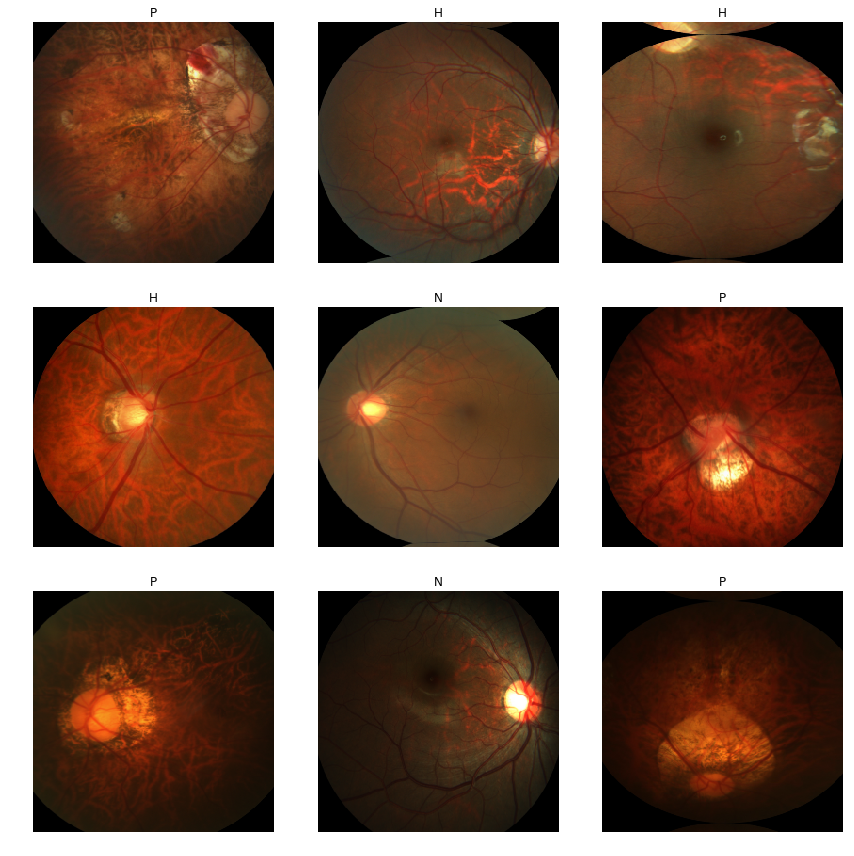

In [ ]:
data.show_batch(rows=3)

## Training

In [ ]:
cbfs = [partial(SaveModelCallback,every='epoch',name='res50_256'),
        ShowGraph]

In [ ]:
learner= cnn_learner(data, models.resnet50, metrics= [accuracy], callback_fns=cbfs)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 44136241.19it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


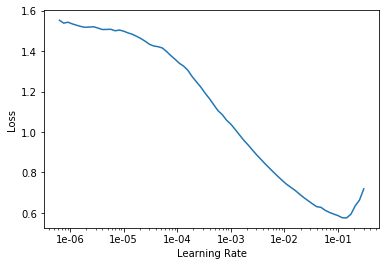

In [ ]:
learner.lr_find()
learner.recorder.plot()

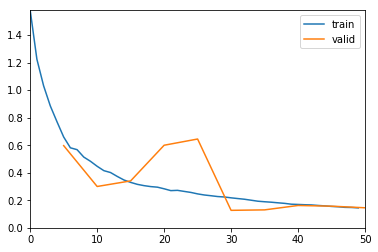

In [ ]:
lr= 1e-2
learner.fit_one_cycle(10, lr)

In [ ]:
# learner.save('res50_256_975acc')
learner.export('models/res50_256_975acc.pkl')

In [ ]:
!ls PALM/PALM-Training400/models
path_local_models=train_path/'models'
stage_file ='res50_256_975acc.pth'
model_file ='res50_256_975acc.pkl'
ls_gcp(path_ophthalmology_models)


res50_256_0.pth   res50_256_15.pth  res50_256_4.pth	  res50_256_975acc.pth
res50_256_10.pth  res50_256_16.pth  res50_256_5.pth	  res50_256_9.pth
res50_256_11.pth  res50_256_17.pth  res50_256_6.pth	  tmp.pth
res50_256_12.pth  res50_256_1.pth   res50_256_7.pth
res50_256_13.pth  res50_256_2.pth   res50_256_8.pth
res50_256_14.pth  res50_256_3.pth   res50_256_975acc.pkl
Copying file://PALM/PALM-Training400/models/res50_256_975acc.pth [Content-Type=application/octet-stream]...
|
Operation completed over 1 objects/114.5 MiB.                                    
gs://medbotai/models/Ophthalmology/Pathological_Myopia/res50_256_975acc.pkl
gs://medbotai/models/Ophthalmology/Pathological_Myopia/res50_256_975acc.pth


In [ ]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

## Evaluation

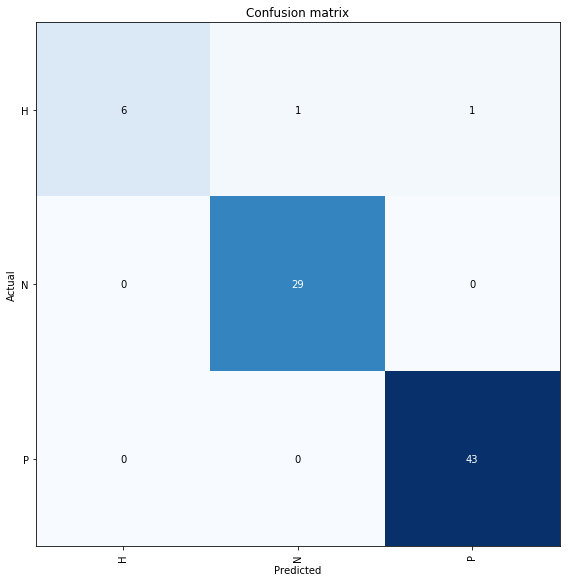

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(10,8))

In [ ]:
preds, y_true=learner.get_preds()
y_true.shape, preds.shape

(torch.Size([80]), torch.Size([80, 3]))

In [ ]:
y_true=y_true.numpy() 
preds=np.argmax(preds.numpy(), axis=-1)
y_true.shape, preds.shape

((80,), (80,))

In [ ]:
classes=['P','N','H']
report = classification_report(y_true, preds, target_names=classes)
print(report)

              precision    recall  f1-score   support

           P       1.00      0.75      0.86         8
           N       0.97      1.00      0.98        29
           H       0.98      1.00      0.99        43

    accuracy                           0.97        80
   macro avg       0.98      0.92      0.94        80
weighted avg       0.98      0.97      0.97        80



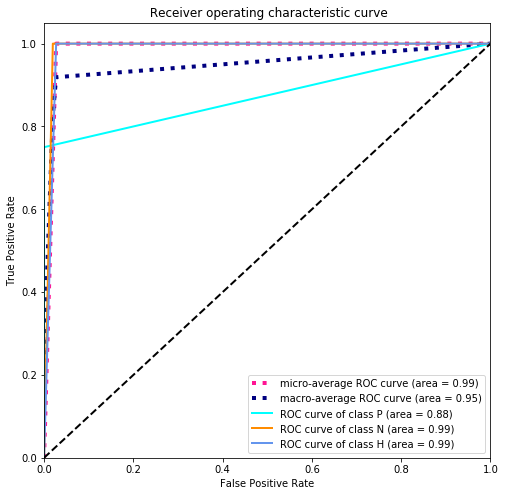

In [ ]:
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc

y_true = y_true.numpy() if not isinstance(y_true, np.ndarray) else y_true
preds = np.argmax(preds.numpy(), axis=-1) if not isinstance(preds, np.ndarray) else preds

y_true_onehot = np.array(pd.get_dummies(y_true))
preds_onehot = np.array(pd.get_dummies(preds))

fpr, tpr, roc_auc = dict(), dict(), dict()
n_classes = y_true_onehot.shape[1]  

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], preds_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true_onehot.ravel(), preds_onehot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(8, 8))

plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
classes = range(n_classes) 
for i, color in zip(classes, colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

Average precision score, micro-averaged over all classes: 0.96


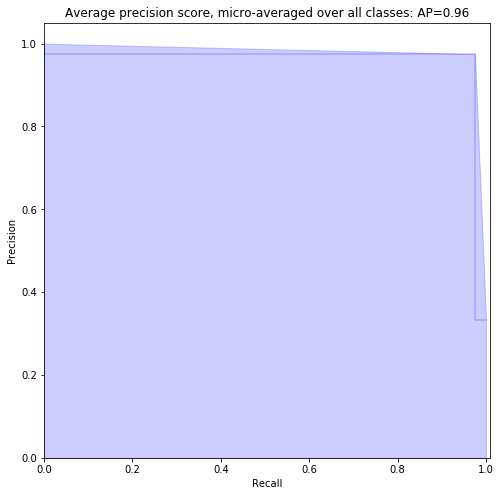

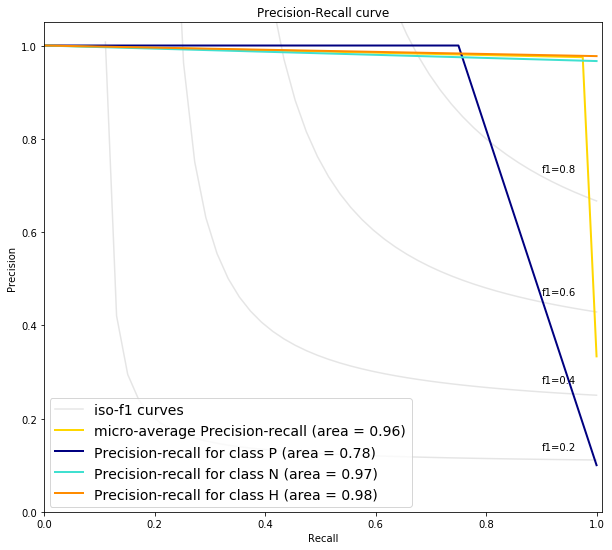

In [ ]:
from sklearn.metrics import precision_recall_curve,average_precision_score
from inspect import signature


def pr_curve(Y_test,y_score, classes, micro=True,isof1=True, **step_kwargs):
  precision = dict()
  recall = dict()
  average_precision = dict()
  n_classes=len(classes)
  for i in range(n_classes):
      precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                          y_score[:, i])
      average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

  precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
      y_score.ravel())
  average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                       average="micro")
  print('Average precision score, micro-averaged over all classes: {0:0.2f}'
        .format(average_precision["micro"]))
  
  if micro:
    plt.figure(figsize=(8, 8))
    plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b',
                     **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.01])
    plt.title(
        'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
        .format(average_precision["micro"]))
    
  if isof1:
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    plt.figure(figsize=(10, 10))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append('iso-f1 curves')
    l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
    lines.append(l)
    labels.append('micro-average Precision-recall (area = {0:0.2f})'
                  ''.format(average_precision["micro"]))

    for c,i, color in zip(classes,range(n_classes), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                      ''.format(c, average_precision[i]))

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.2)
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(lines, labels, loc=(0.01, 0.01), prop=dict(size=14))
  
pr_curve(np.array(pd.get_dummies(y_true)), np.array(pd.get_dummies(preds)), classes)
  

# Disc Detection and Segmentation

In [ ]:
path_disc = (path/'Disc_Masks')
len(path_disc.ls()), path_disc.ls()[:5]

(400,
 [PosixPath('PALM/Disc_Masks/H0013.bmp'),
  PosixPath('PALM/Disc_Masks/N0120.bmp'),
  PosixPath('PALM/Disc_Masks/H0005.bmp'),
  PosixPath('PALM/Disc_Masks/N0016.bmp'),
  PosixPath('PALM/Disc_Masks/N0068.bmp')])

In [ ]:
get_mask_lb=lambda x: path_disc/(x.name[:-4]+'.bmp')
mask=open_mask(get_mask_lb(train_path.ls()[0]))
print(mask.shape)

torch.Size([1, 2056, 2124])


## Training U-Net

In [ ]:
class DiscSegmentationLabelList(SegmentationLabelList):
  def open(self, fn): return open_mask(fn, div=True)
  
class DiscSegmentationItemList(ImageList):
  _label_cls= DiscSegmentationLabelList

In [ ]:
src= (DiscSegmentationItemList.from_folder(train_path)
      .split_by_rand_pct()
      .label_from_func(get_mask_lb, classes=['Disc','void']))
src

LabelLists;

Train: LabelList (320 items)
x: DiscSegmentationItemList
Image (3, 2056, 2124),Image (3, 2056, 2124),Image (3, 2056, 2124),Image (3, 2056, 2124),Image (3, 2056, 2124)
y: DiscSegmentationLabelList
ImageSegment (1, 2056, 2124),ImageSegment (1, 2056, 2124),ImageSegment (1, 2056, 2124),ImageSegment (1, 2056, 2124),ImageSegment (1, 2056, 2124)
Path: PALM/PALM-Training400;

Valid: LabelList (80 items)
x: DiscSegmentationItemList
Image (3, 2056, 2124),Image (3, 2056, 2124),Image (3, 2056, 2124),Image (3, 2056, 2124),Image (3, 2056, 2124)
y: DiscSegmentationLabelList
ImageSegment (1, 2056, 2124),ImageSegment (1, 2056, 2124),ImageSegment (1, 2056, 2124),ImageSegment (1, 2056, 2124),ImageSegment (1, 2056, 2124)
Path: PALM/PALM-Training400;

Test: None

In [ ]:
def get_segmentation_data(bs=16, size=256, **kwargs):
  return (src.transform(get_transforms(flip_vert=True), size=size, tfm_y=True)
          .databunch(bs=bs, num_workers=0, **kwargs)
          .normalize())

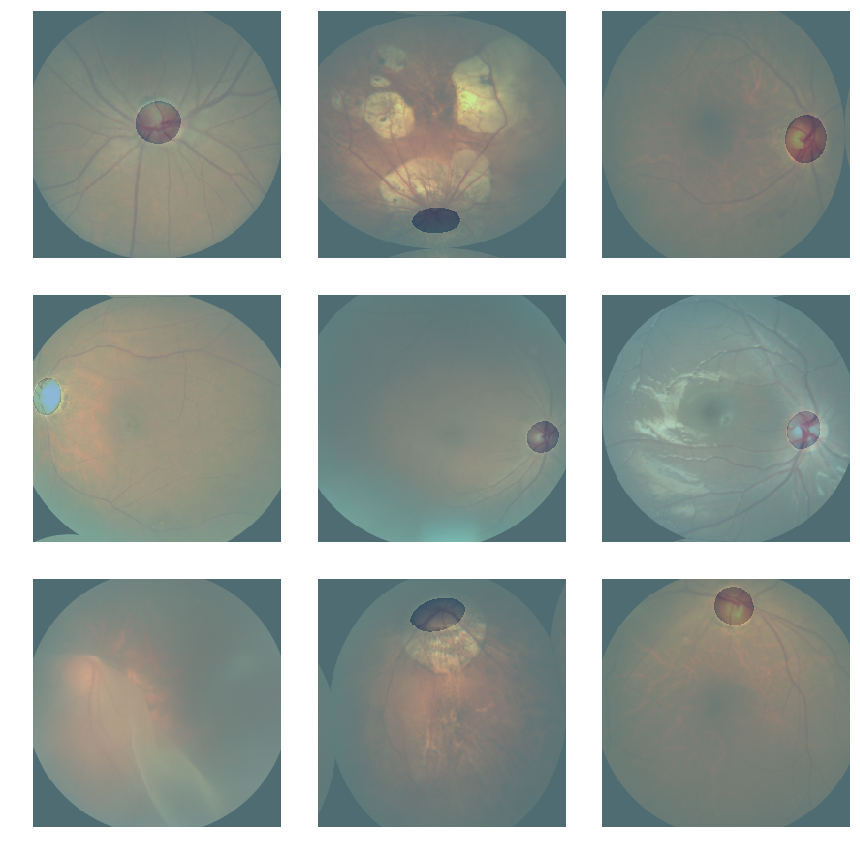

In [ ]:
data= get_segmentation_data()
data.show_batch(rows=3)

In [ ]:
cbfs = [partial(SaveModelCallback,every='epoch',name='unet_256'),
        ShowGraph]

In [ ]:
learner = unet_learner(data, models.resnet34, metrics=[dice], callback_fns=cbfs)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 45183021.04it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


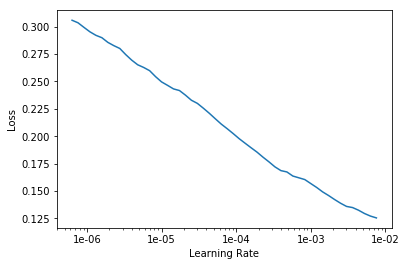

In [ ]:
learner.lr_find()
learner.recorder.plot()

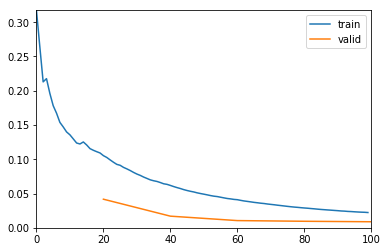

In [ ]:
lr= 1e-3
learner.fit_one_cycle(2, max_lr=slice(1e-4, lr), wd=1e-2)

In [ ]:
learner.save('disc_unet_256_999dice')
learner.export('models/disc_unet_256_999dice.pkl')

In [ ]:
!ls PALM/PALM-Training400/models
path_local_models=train_path/'models'
stage_file ='disc_unet_256_999dice.pth'
model_file ='disc_unet_256_999dice.pkl'
upload_files_to_gcp(path_local_models/model_file, path_ophthalmology_models)
ls_gcp(path_ophthalmology_models)

disc_unet_256_999dice.pkl  res50_256_17.pth	 res50_256_975acc.pth
disc_unet_256_999dice.pth  res50_256_1.pth	 res50_256_9.pth
res50_256_0.pth		   res50_256_2.pth	 tmp.pth
res50_256_10.pth	   res50_256_3.pth	 unet_256_0.pth
res50_256_11.pth	   res50_256_4.pth	 unet_256_1.pth
res50_256_12.pth	   res50_256_5.pth	 unet_256_2.pth
res50_256_13.pth	   res50_256_6.pth	 unet_256_3.pth
res50_256_14.pth	   res50_256_7.pth	 unet_256_4.pth
res50_256_15.pth	   res50_256_8.pth	 unet_256_999dice.pkl
res50_256_16.pth	   res50_256_975acc.pkl  unet_256_999dice.pth
Copying file://PALM/PALM-Training400/models/disc_unet_256_999dice.pkl [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite obj

## Evaluation

In [ ]:
interp = SegmentationInterpretation.from_learner(learner)
top_losses, top_idxs = interp.top_losses(sizes=(256,256))

['void', 'Disc']


label     score
1  Disc  0.997877
0  void  0.923421

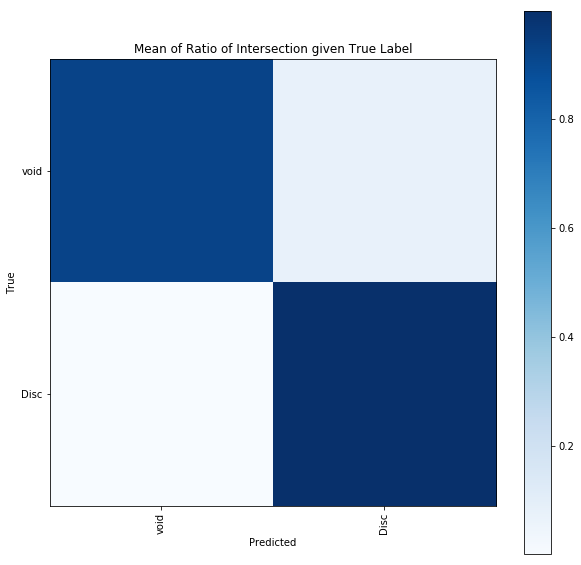

In [ ]:
print(learner.data.classes)
mean_cm, single_img_cm = interp._generate_confusion()
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")
df

label     score
1  Disc  0.990742
0  void  0.847362

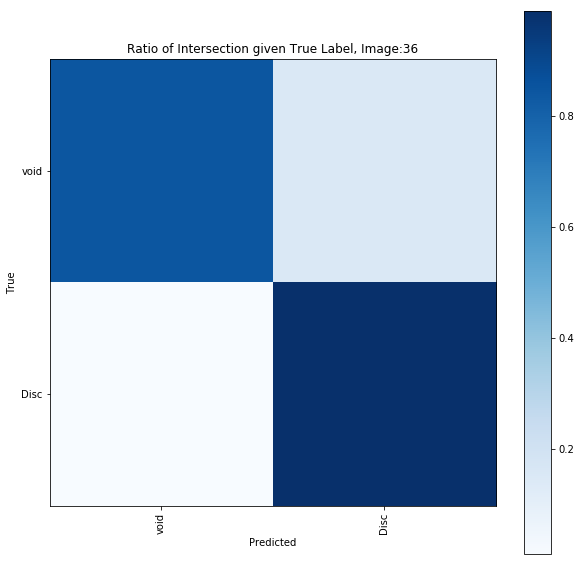

In [ ]:
i = top_idxs[1]
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")
df

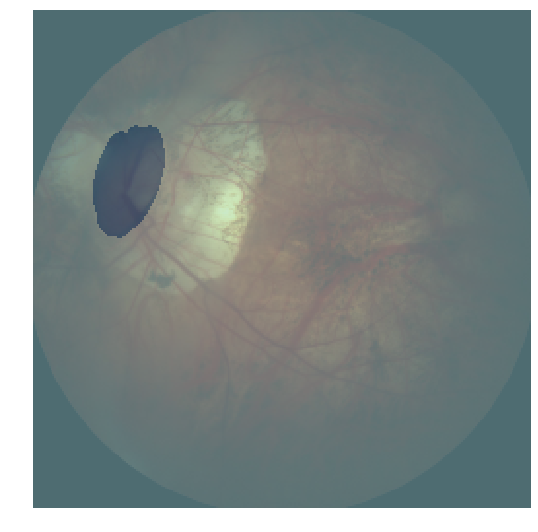

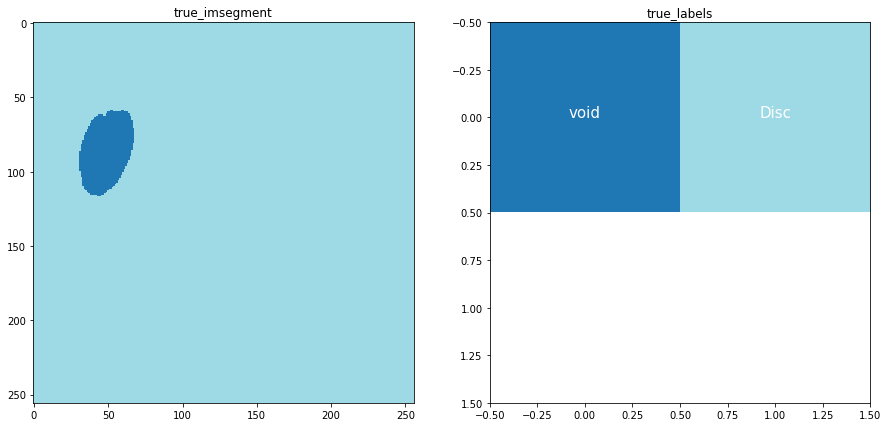

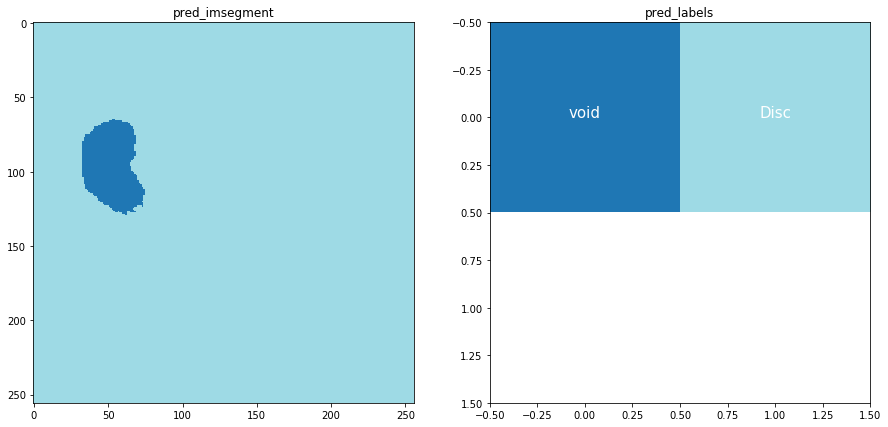

In [ ]:
interp.show_xyz(i, sz=15)

# Lesion Detection and Segmentation

## Data

In [ ]:
path.ls()

[PosixPath('PALM/Validation-400'),
 PosixPath('PALM/Disc_Fovea_Illustration'),
 PosixPath('PALM/Lesion_Masks'),
 PosixPath('PALM/Fovea_Location.xlsx'),
 PosixPath('PALM/Disc_Masks'),
 PosixPath('PALM/__MACOSX'),
 PosixPath('PALM/Lesion_Illustration'),
 PosixPath('PALM/PALM-Training400')]

In [ ]:
lesion_path=path/'Lesion_Masks'
lesion_path.ls()

[PosixPath('PALM/Lesion_Masks/Atrophy'),
 PosixPath('PALM/Lesion_Masks/.DS_Store'),
 PosixPath('PALM/Lesion_Masks/Detachment')]

In [ ]:
len((lesion_path/'Atrophy').ls()), len((lesion_path/'Detachment').ls())

(311, 12)

In [ ]:
(lesion_path/'Detachment').ls()[0]

PosixPath('PALM/Lesion_Masks/Detachment/P0078.bmp')

In [ ]:
def get_masks(fn): 
  at_fn = (lesion_path/'Atrophy')/(fn.name[:-4]+'.bmp')
  dt_fn = (lesion_path/'Detachment')/(fn.name[:-4]+'.bmp')
  if at_fn.exists():
    return at_fn
    
print(len([get_masks((lesion_path/'Detachment').ls()[i]) for i in range(12)]))
fm=[get_masks((lesion_path/'Detachment').ls()[i]) for i in range(12)]
fm

12


[None,
 None,
 PosixPath('PALM/Lesion_Masks/Atrophy/P0068.bmp'),
 PosixPath('PALM/Lesion_Masks/Atrophy/P0018.bmp'),
 PosixPath('PALM/Lesion_Masks/Atrophy/P0134.bmp'),
 None,
 PosixPath('PALM/Lesion_Masks/Atrophy/P0058.bmp'),
 PosixPath('PALM/Lesion_Masks/Atrophy/P0154.bmp'),
 PosixPath('PALM/Lesion_Masks/Atrophy/P0199.bmp'),
 PosixPath('PALM/Lesion_Masks/Atrophy/P0053.bmp'),
 PosixPath('PALM/Lesion_Masks/Atrophy/P0067.bmp'),
 PosixPath('PALM/Lesion_Masks/Atrophy/P0062.bmp')]

In [ ]:
img_fn=train_path.ls()[0]

In [ ]:
def open_lesion_mask(fn:PathOrStr, div=True, convert_mode='L', cls:type=ImageSegment, after_open:Callable=None)->ImageSegment:
    "Return `ImageSegment` object create from mask in file `fn`. If `div`, divides pixel values by 255."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        if len(fn)==2: 
          x1 = pil2tensor(PIL.Image.open(fn[0]).convert(convert_mode), np.float32)
          x2 = pil2tensor(PIL.Image.open(fn[1]).convert(convert_mode), np.float32)
          x1[x1==255], x2[x2==255]= 1, 2
          print(f'x1 {x1.shape}, x2 {x2.shape}')
          x = x1+x2
          print(x.unique())
        else: 
          x = PIL.Image.open(fn[0]).convert(convert_mode)
          x = pil2tensor(x,np.float32)
          if div: x.div_(255)
    return cls(x)
    

In [ ]:
mask = open_lesion_mask(fm[2])

x1 torch.Size([1, 2056, 2124]), x2 torch.Size([1, 2056, 2124])
tensor([0., 1., 3.])


In [ ]:
train_path.ls()[0]

PosixPath('PALM/PALM-Training400/N0146.jpg')

In [ ]:
atropy_files= [train_path/(f.name[:-4]+'.jpg') for f in (lesion_path/'Atrophy').ls()]
atropy_files[:5]

[PosixPath('PALM/PALM-Training400/N0131.jpg'),
 PosixPath('PALM/PALM-Training400/N0138.jpg'),
 PosixPath('PALM/PALM-Training400/P0206.jpg'),
 PosixPath('PALM/PALM-Training400/P0104.jpg'),
 PosixPath('PALM/PALM-Training400/N0117.jpg')]

In [ ]:
class LesionSegmentationLabelList(SegmentationLabelList):
  def open(self, fn): return open_mask(fn, div=True)
  
class LesionSegmentationItemList(ImageList):
  _label_cls= LesionSegmentationLabelList

In [ ]:
src= (LesionSegmentationItemList(atropy_files)
      .split_by_rand_pct()
      .label_from_func(get_masks, classes=['void','atrophy lesion']))
src

LabelLists;

Train: LabelList (249 items)
x: LesionSegmentationItemList
Image (3, 2056, 2124),Image (3, 2056, 2124),Image (3, 2056, 2124),Image (3, 2056, 2124),Image (3, 2056, 2124)
y: LesionSegmentationLabelList
ImageSegment (1, 2056, 2124),ImageSegment (1, 2056, 2124),ImageSegment (1, 2056, 2124),ImageSegment (1, 2056, 2124),ImageSegment (1, 2056, 2124)
Path: .;

Valid: LabelList (62 items)
x: LesionSegmentationItemList
Image (3, 2056, 2124),Image (3, 2056, 2124),Image (3, 2056, 2124),Image (3, 2056, 2124),Image (3, 2056, 2124)
y: LesionSegmentationLabelList
ImageSegment (1, 2056, 2124),ImageSegment (1, 2056, 2124),ImageSegment (1, 2056, 2124),ImageSegment (1, 2056, 2124),ImageSegment (1, 2056, 2124)
Path: .;

Test: None

In [ ]:
def get_segmentation_data(bs=16, size=256, **kwargs):
  return (src.transform(get_transforms(flip_vert=True), size=size, tfm_y=True)
          .databunch(bs=bs, num_workers=0, **kwargs)
          .normalize())

In [ ]:
data= get_segmentation_data() 

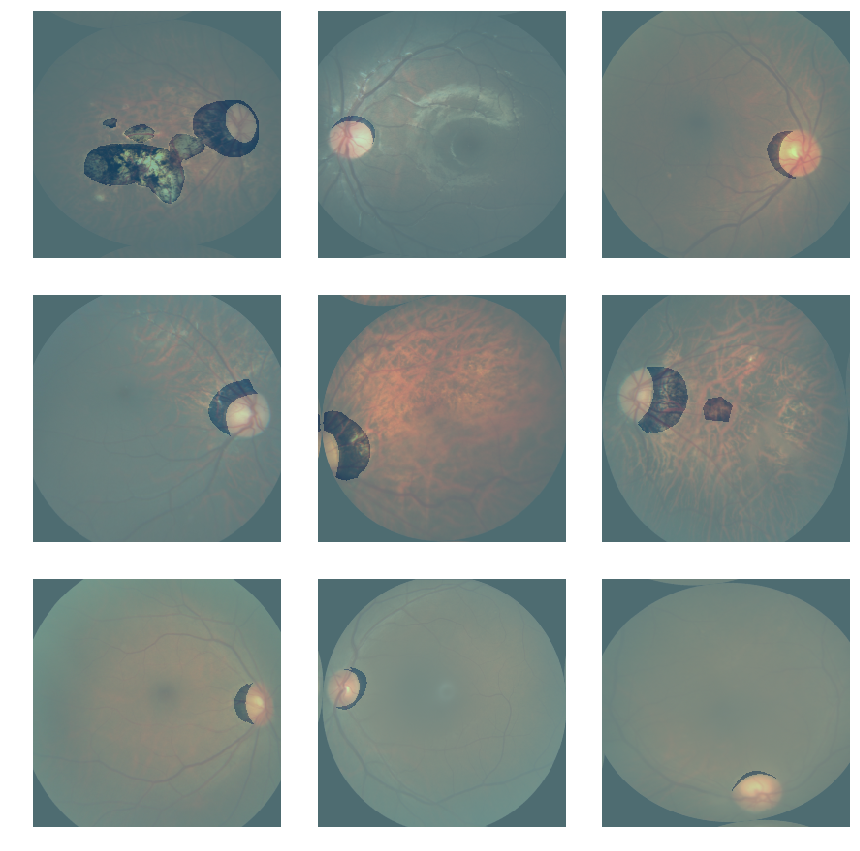

In [ ]:
data.show_batch(rows=3)

## Training

In [ ]:
cbfs = [partial(SaveModelCallback,every='epoch',name='unet_256'),
        ShowGraph]

In [ ]:
learner = unet_learner(data, models.resnet34, metrics=[dice], callback_fns=cbfs)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:05<00:00, 17308131.25it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


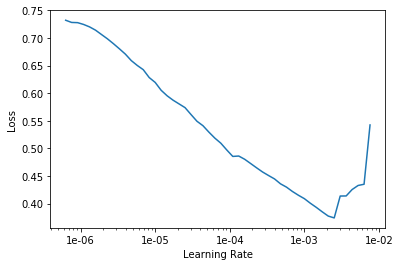

In [ ]:
learner.lr_find()
learner.recorder.plot()

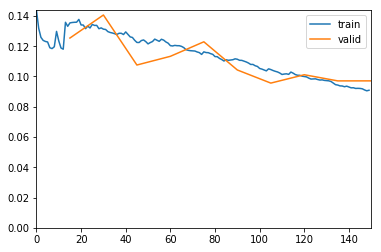

In [ ]:
lr= 1e-3
learner.fit_one_cycle(10, max_lr=slice(1e-4, lr), wd=1e-2) 

In [ ]:
learner.save('lesion_unet_256-98d')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


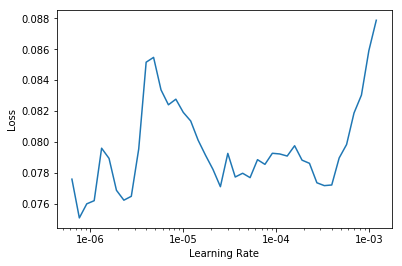

In [ ]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot()

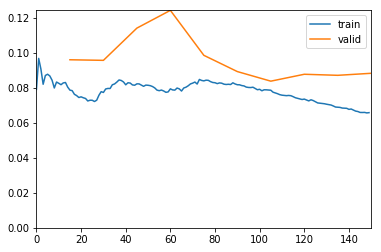

In [ ]:
lr= 1e-4
learner.fit_one_cycle(10, max_lr=slice(1e-5, 5*lr), wd=1e-2) 

In [ ]:
learner.save('lesion_unet_256-982d')

## Evaluation

In [ ]:
interp = SegmentationInterpretation.from_learner(learner)
top_losses, top_idxs = interp.top_losses(sizes=(256,256))

['void', 'atrophy lesion']


label     score
1  atrophy lesion  0.989089
0            void    0.6313

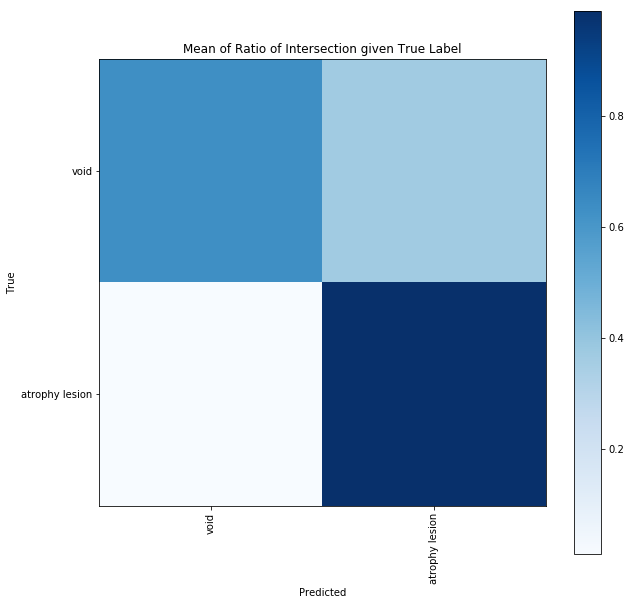

In [ ]:
print(learner.data.classes)
mean_cm, single_img_cm = interp._generate_confusion()
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")
df

label     score
1  atrophy lesion  0.998681
0            void   0.69312

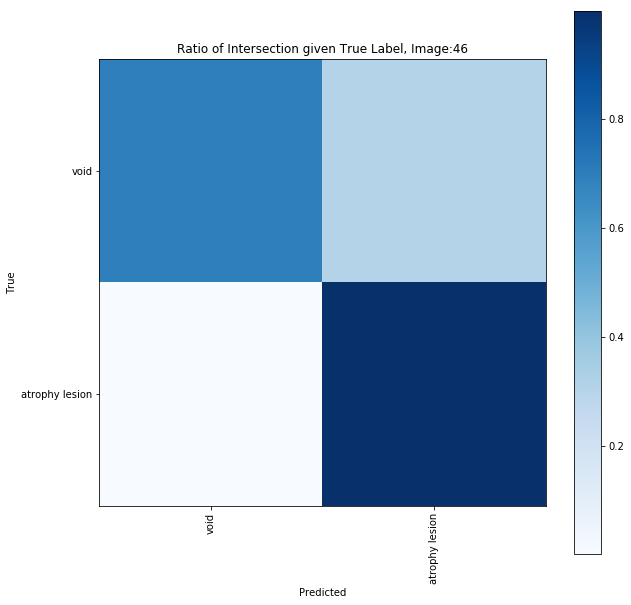

In [ ]:
i = top_idxs[3]
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")
df

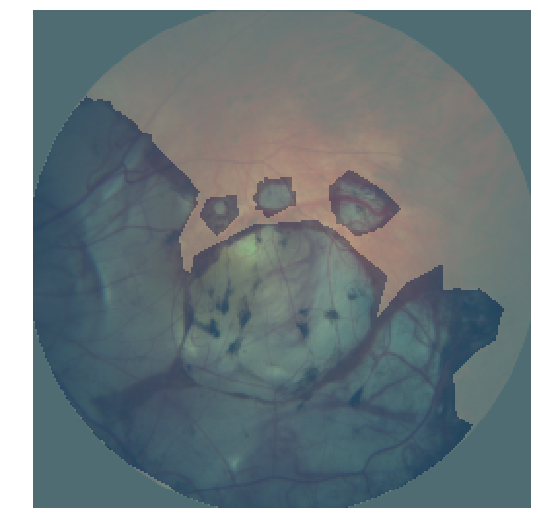

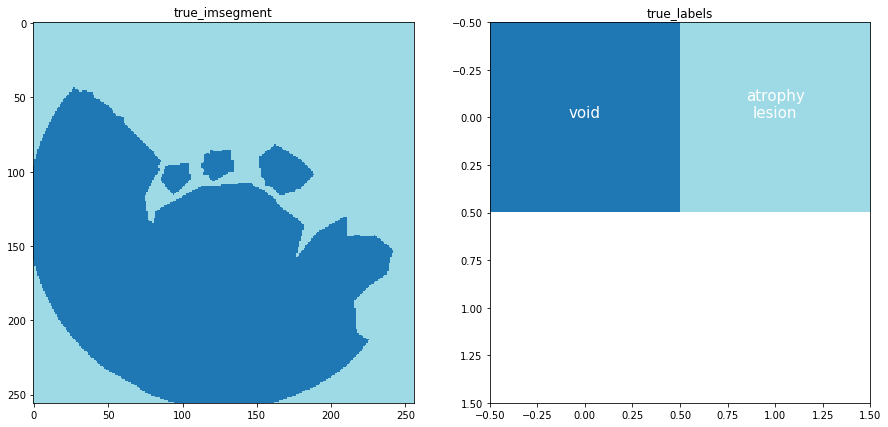

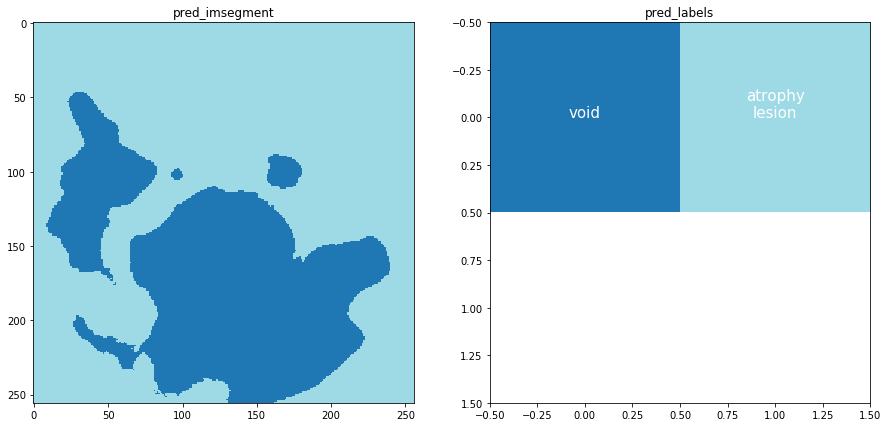

In [ ]:
interp.show_xyz(i, sz=15)

# Fovea Localization

## Data

In [ ]:
path.ls()

[PosixPath('PALM/Disc_Fovea_Illustration'),
 PosixPath('PALM/__MACOSX'),
 PosixPath('PALM/PALM-Training400'),
 PosixPath('PALM/Fovea_Location.xlsx'),
 PosixPath('PALM/Lesion_Masks'),
 PosixPath('PALM/Validation-400'),
 PosixPath('PALM/Disc_Masks'),
 PosixPath('PALM/Lesion_Illustration')]

In [ ]:
fovea_df= pd.read_excel(path/'Fovea_Location.xlsx').set_index('imgName')
fovea_df = fovea_df.drop(columns='ID')
fovea_df.head()

Fovea_X  Fovea_Y
imgName                    
H0001.jpg   743.96   790.54
H0002.jpg  1394.82   725.54
H0003.jpg  1361.74   870.72
H0004.jpg   703.15   742.44
H0005.jpg  1070.95  1037.54

In [ ]:
def get_location(fn:Path):
  points= fovea_df.loc[str(fn.name)]
  return torch.tensor([[points.Fovea_Y, points.Fovea_X]])

In [ ]:
img_fn = train_path.ls()[0]
get_location(img_fn).shape

torch.Size([1, 2])

In [ ]:
src=(PointsItemList.from_folder(train_path)
      .split_by_rand_pct()
      .label_from_func(get_location))

In [ ]:
def get_data_points(bs=32, size=256,**kwargs):
  return (src.transform(tfms=get_transforms(flip_vert=True), size=size, tfm_y=True, resize_method=ResizeMethod.SQUISH, remove_out=False)
          .databunch(bs=bs, **kwargs)
          .normalize())

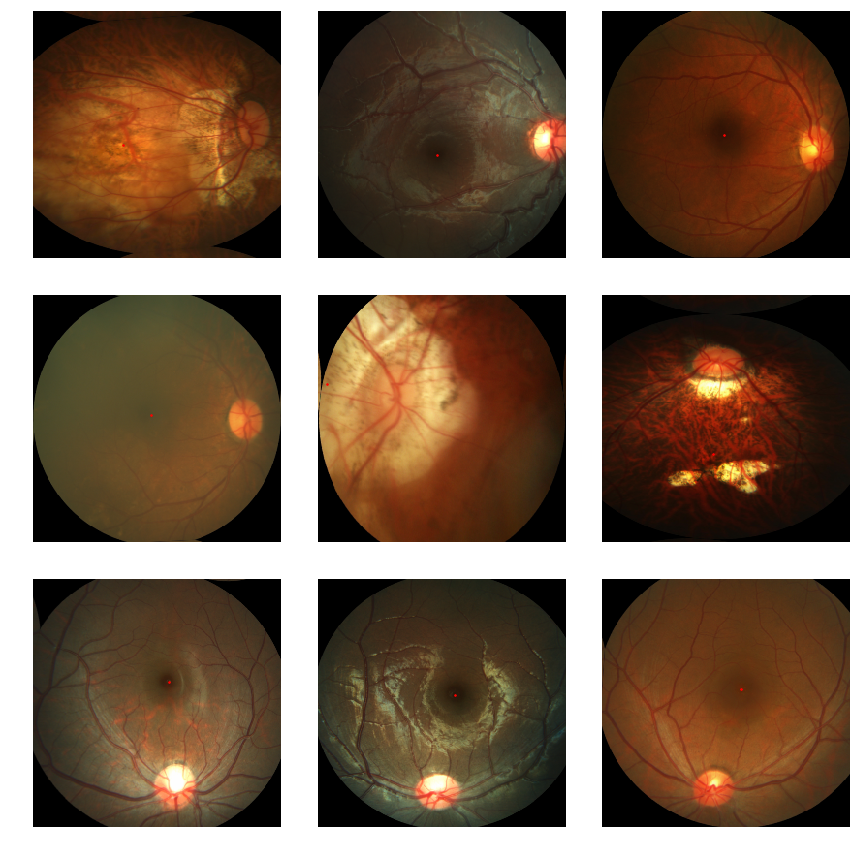

In [ ]:
data= get_data_points()
data.show_batch(rows=3)

## Model & Training

In [ ]:
class PointsDetector(nn.Module):
  def __init__(self, arch=models.resnet34, points_count=1,**kwargs):
    super().__init__()
    self.points_count= points_count
    self.cnn= create_body(arch)
    self.head=create_head(2*num_features_model(self.cnn), 2*points_count)
    
  def forward(self, img):
    bs = img.shape[0]
    x = self.cnn(img)
    x = self.head(x)
    activations = 2*(x.sigmoid_()-0.5)
    return activations.reshape(bs, self.points_count, 2)

In [ ]:
m=PointsDetector(arch=models.resnet50)

In [ ]:
num_features_model(nn.Sequential(*m.children()))

2

In [ ]:
model_sizes(nn.Sequential(*m.children()))

[torch.Size([1, 2048, 2, 2]), torch.Size([1, 2])]

In [ ]:
def loss_func(preds, targets, loss='Smooth'): 
  if loss=='L1': return L1Loss()(preds, targets)
  elif loss== 'Smooth': return SmoothL1Loss()(preds, targets)
  elif loss=='MSE': return MSELoss()(preds,targets)

def points_learner(data:DataBunch, model:Callable, loss_func=loss_func,init=nn.init.kaiming_normal_, **kwargs):
  learn = Learner(data, PointsDetector(arch=model), loss_func=loss_func, **kwargs)
  learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])
  if init: apply_init(learn.model, init)
  return learn

In [ ]:
cbfs = [partial(SaveModelCallback,every='epoch',name='points_res50_256'),
        ShowGraph]

learner= points_learner(data, models.resnet50, metrics=[mean_squared_error, root_mean_squared_error], callback_fns=cbfs )

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


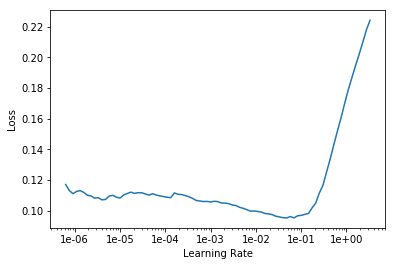

In [ ]:
learner.lr_find()
learner.recorder.plot()

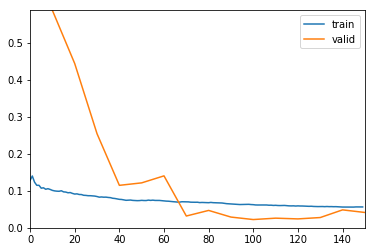

In [ ]:
lr = 1e-2
learner.fit_one_cycle(15, lr)

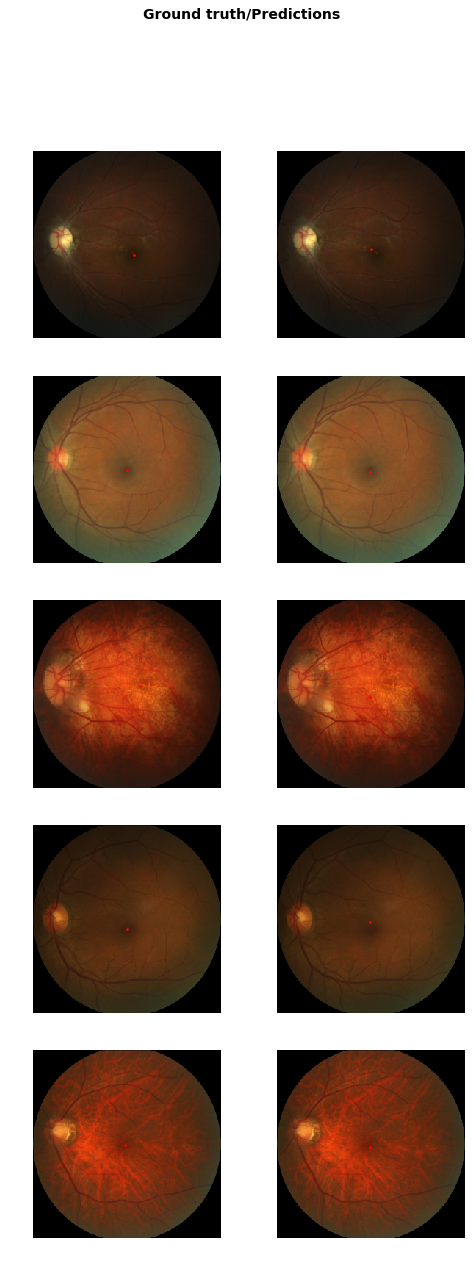

In [ ]:
learner.show_results()

In [ ]:
learner.save('fovea_location_res50_256_08mse')
learner.export('models/fovea_location_res50_256_08mse.pkl')

In [ ]:
path_local_models=(train_path)/'models'
stage_file ='fovea_location_res50_256_08mse.pth'
model_file ='fovea_location_res50_256_08mse.pkl'
upload_files_to_gcp(path_local_models/stage_file, path_ophthalmology_models)
ls_gcp(path_ophthalmology_models)

Copying file://PALM/PALM-Training400/models/fovea_location_res50_256_08mse.pth [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\
Operation completed over 1 objects/293.5 MiB.                                    
gs://medbotai/models/Ophthalmology/Pathological_Myopia/disc_unet_256_999dice.pkl
gs://medbotai/models/Ophthalmology/Pa